# High Dimensional Weighted Gene Correlation Network Analysis (hdWGCNA)

**Authorship:**
Adam Klie, *08/24/2022*
***
**Description:**
Notebook to run a WGCNA on stimulated pancreatic islet multiome data (well just the RNA)
***
<div class="alert alert-block alert-warning">
<b>TODOs</b>:
<ul>
    <b><li></li></b>
    <b><li></li></b>
    <b><li></li></b>
    </ul>
</div>

# Conversion and loading

In [18]:
# Conversion libraries
library(SeuratDisk)
library(SeuratData)
library(Seurat)

In [19]:
# Try a couple different saved h5ads
#H5AD_FILE="/cellar/users/aklie/data/beta_cell_networks/multiomic_stimulated_islet/31may22_islet_multiome.h5ad"
H5AD_FILE="31may22_islet_multiome_cleaned.h5ad"
#H5AD_FILE="31may22_islet_multiome_raw_cleaned.h5ad"
#H5AD_FILE="31may22_islet_multiome_gzip.h5ad"

In [20]:
# Convert to h5seurat
Convert(H5AD_FILE, dest = "h5seurat", overwrite = TRUE)

Warning message:
“Unknown file type: h5ad”
Warning message:
“'assay' not set, setting to 'RNA'”
Creating h5Seurat file for version 3.1.5.9900

Adding X as scale.data

Adding raw/X as data

Adding raw/X as counts

Adding meta.features from raw/var

Merging features from scaled feature-level metadata

Adding X_harmony.sct as cell embeddings for harmony.sct

Adding X_pca as cell embeddings for pca

Adding X_umap.wnn as cell embeddings for umap.wnn

Adding HARMONY.SCT as feature loadings fpr harmony.sct

Adding PCs as feature loadings fpr pca



In [ ]:
# Load in the seurat object from the cleaned version
adata <- LoadH5Seurat("31may22_islet_multiome_cleaned.h5seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding scale.data for RNA

Adding feature-level metadata for RNA

Adding reduction harmony.sct

Adding cell embeddings for harmony.sct

Adding feature loadings for harmony.sct

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from harmony.sct_ to harmonysct_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to harmonysct_”
Adding miscellaneous information for harmony.sct

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap.wnn

Adding cell embeddings for umap.wnn

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap.wnn_ to umapwnn_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an under

In [ ]:
# Check it!
adata

# hdWGCNA

In [41]:
# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




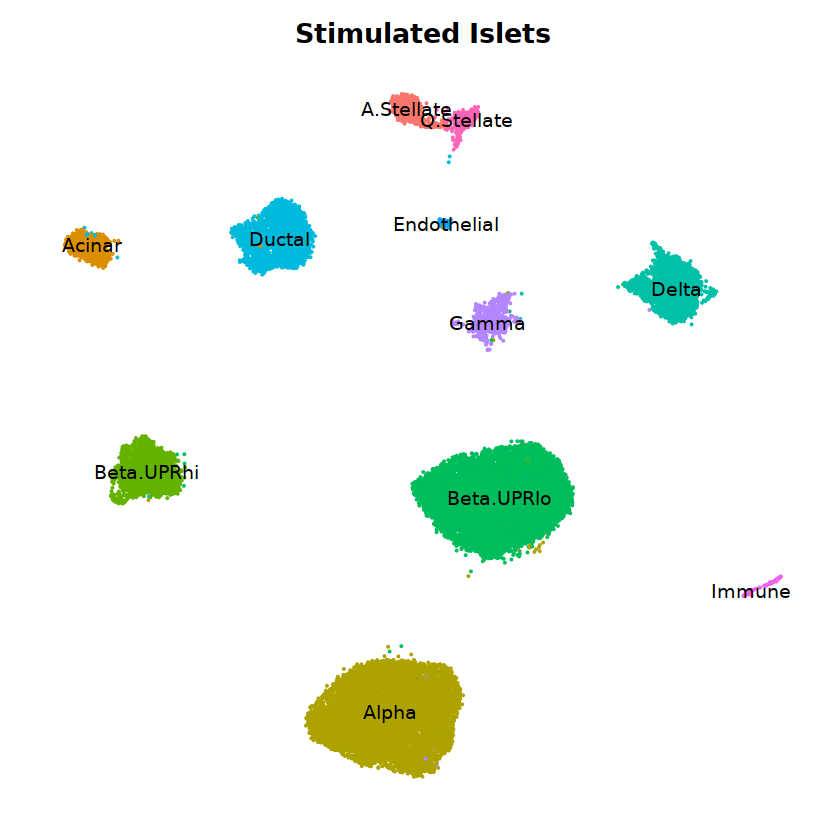

In [42]:
# Double check the umaps for clustering
p <- DimPlot(adata, group.by='cell.type', label=TRUE) +
   umap_theme() + ggtitle('Stimulated Islets') + NoLegend()
p

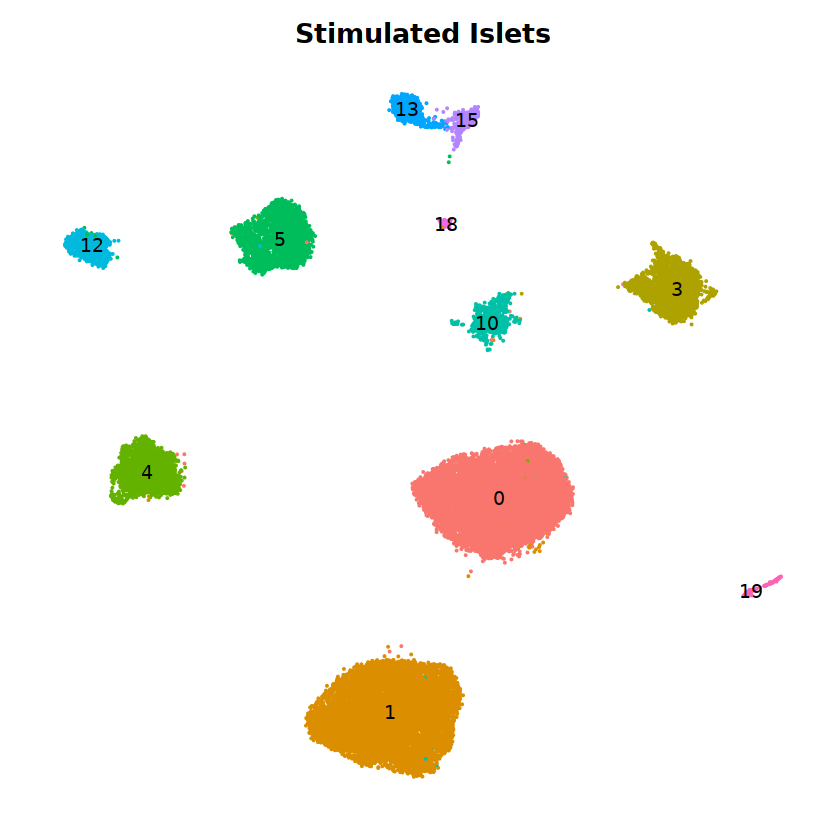

In [50]:
p <- DimPlot(adata, group.by='seurat_clusters', label=TRUE) +
   umap_theme() + ggtitle('Stimulated Islets') + NoLegend()
p

In [53]:
# Set-up a Seurat object for WGCNA
seurat_obj <- SetupForWGCNA(
  adata,
  gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "stimulated_islets" # the name of the hdWGCNA experiment
)

In [56]:
# construct metacells  in each group
seurat_obj <- MetacellsByGroups(
  seurat_obj = seurat_obj,
  group.by = c("cell.type"), # specify the columns in adata@meta.data to group by
  k = 25, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'cell.type' # set the Idents of the metacell seurat object
)

[1] "done making metacells"
[1] 11
[1] "metacell shape"


In [57]:
# normalize metacell expression matrix:
seurat_obj <- NormalizeMetacells(seurat_obj)

In [63]:
table(seurat_obj$cell.type)


 A.Stellate      Acinar       Alpha  Beta.UPRhi  Beta.UPRlo       Delta 
        651         754        9343        2378        9453        2385 
     Ductal Endothelial       Gamma      Immune  Q.Stellate 
       2345         171         941         168         388 

In [64]:
seurat_obj <- SetDatExpr(
  seurat_obj,
  group_name = "Beta.UPRlo", # the name of the group of interest in the group.by column
  group.by='cell.type' # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
)

Warning message in SetDatExpr(seurat_obj, group_name = "Beta.UPRlo", group.by = "cell.type"):
“assay not specified, trying to use assay RNA”


pickSoftThreshold: will use block size 4993.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4993 of 8960


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 4994 through 8960 of 8960


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.5390  85.80          0.765 4.49e+03  4.50e+03 4570.00
2      2   0.0137   6.49          0.864 2.27e+03  2.27e+03 2400.00
3      3   0.0994  -9.69          0.815 1.15e+03  1.15e+03 1310.00
4      4   0.4170 -12.60          0.675 5.90e+02  5.85e+02  745.00
5      5   0.6960 -11.50          0.742 3.04e+02  2.99e+02  446.00
6      6   0.9520 -10.50          0.950 1.58e+02  1.53e+02  279.00
7      7   0.9960  -8.43          0.996 8.28e+01  7.91e+01  182.00
8      8   0.9890  -6.76          0.989 4.38e+01  4.09e+01  123.00
9      9   0.9820  -5.56          0.981 2.34e+01  2.13e+01   87.00
10    10   0.9840  -4.65          0.986 1.27e+01  1.11e+01   63.40
11    12   0.9710  -3.43          0.977 3.91e+00  3.06e+00   36.80
12    14   0.9670  -2.60          0.970 1.32e+00  8.54e-01   23.40
13    16   0.9770  -2.02          0.971 5.03e-01  2.43e-01   15.90
14    18   0.9620  -1.75          0.952 2.22e-01  7.03e-02   1

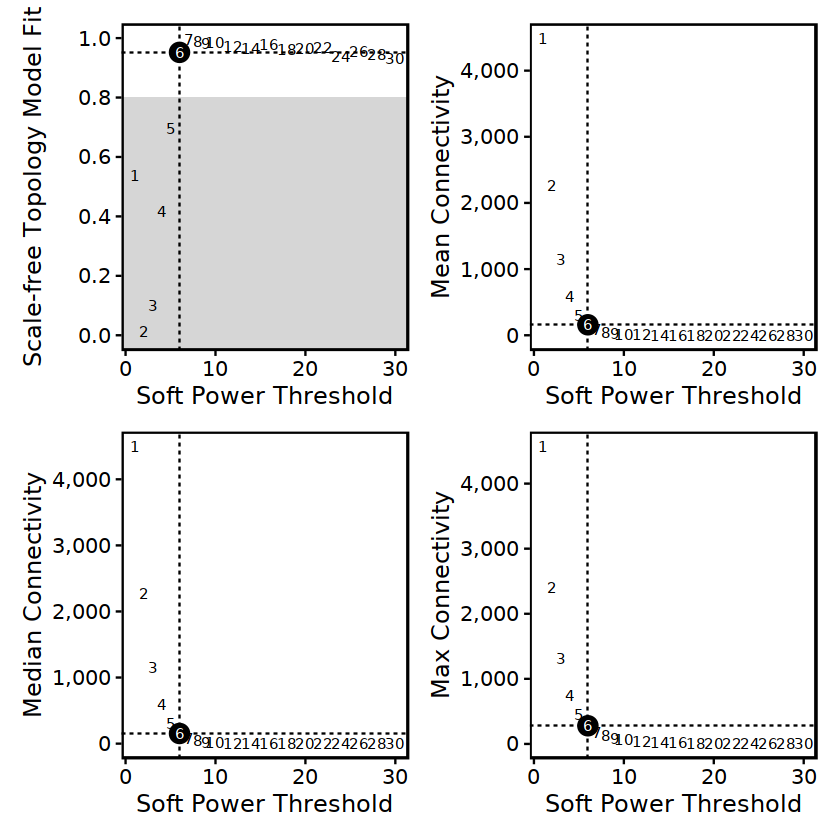

In [65]:
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  setDatExpr = FALSE, # set this to FALSE since we did this above
)

# plot the results:
plot_list <- PlotSoftPowers(seurat_obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [66]:
power_table <- GetPowerTable(seurat_obj)
head(power_table)

,Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.53924305,85.777380,0.7651361,4491.5429,4496.7378,4570.2782
2,2,0.01369644,6.488548,0.8641718,2267.4031,2269.0767,2398.0397
3,3,0.09942894,-9.685246,0.8153344,1152.4331,1149.8912,1308.6113
4,4,0.41700909,-12.599552,0.6754594,589.7981,585.3491,745.1591
5,5,0.69620374,-11.500088,0.7422367,304.0360,299.1613,445.7714
6,6,0.95200270,-10.476245,0.9504972,157.9454,153.4739,278.8691


In [67]:
# construct co-expression network:
seurat_obj <- ConstructNetwork(
  seurat_obj, soft_power=6,
  setDatExpr=FALSE,
  tom_name = 'Beta.UPRlo' # name of the topoligical overlap matrix written to disk
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


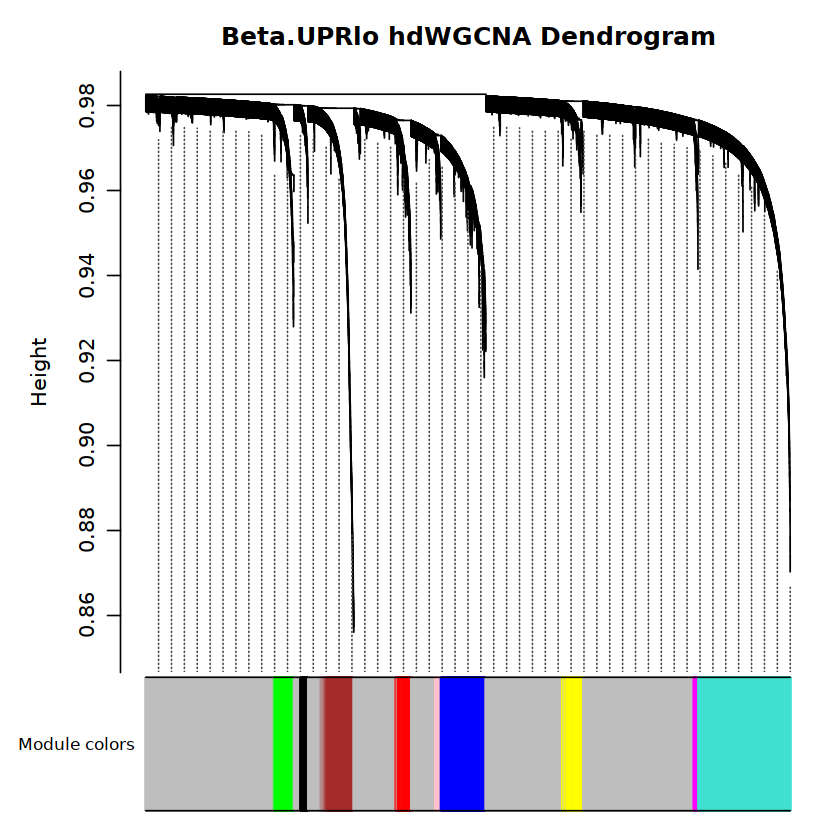

In [68]:
PlotDendrogram(seurat_obj, main='Beta.UPRlo hdWGCNA Dendrogram')

In [70]:
# need to run ScaleData first or else harmony throws an error:
seurat_obj <- ScaleData(seurat_obj, features=VariableFeatures(seurat_obj))

# compute all MEs in the full single-cell dataset
seurat_obj <- ModuleEigengenes(
 seurat_obj,
 group.by.vars="donor"
)

Centering and scaling data matrix



[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”
pcagrey_ 1 
Positive:  OSMR, PTPN14, YAP1, NFIB, ITGA2, PDGFC, NOTCH2, SHANK2, TPM1, GRHL2 
	   WWTR1, CLDN1, EPS8, MET, ADAMTS9, ITGB1-DT, UGCG, ANXA3, TGFA, RASEF 
	   CD59, HSPG2, CYTOR, CFTR, MAP3K20, KRT7, NTN4, PKHD1, IL4R, CASC15 
Negative:  CACNA1D, PTPRN2, MAML3, PLCXD3, NRCAM, MTMR7, NOVA1, TPD52, DYNC1I1, SH3GL2 
	   GABRB3, CPNE4, XPR1, GNAO1, ABCA5, NFASC, PPM1L, RGS17, RPH3AL, FAM135A 
	   SNAP91, G6PC2, MAP2, TMEM196, PARM1, EPB41L3, PCDH17, MEG3, KIF5C, SGCE 
pcagrey_ 2 
Positive:  NFIB, ITGA2, YAP1, OSMR, NOTCH2, PTPN14, PDGFC, CASC15, EPS8, CLDN1 
	   TPM1, WWTR1, RASEF, MSC-AS1, ADAMTS9, GRHL2, SHANK2, IL4R, ITGB1-DT, ABTB2 
	   ITGB6, MAP3K20, HSPG2, MET, NTN4, COL4A2, PKHD

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”
pcaturquoise_ 1 
Positive:  DPP6, KCNMA1, CACNA1C, GNAS, PLCB4, KCNMB2, SNHG14, RIMBP2, CADM1, DACH2 
	   LIMCH1, PLCB1, RAP1GAP2, ELAVL4, ELP4, PAPSS2, ARL15, NEBL, ARFGEF3, LRRTM3 
	   SETBP1, GPR158, MCTP2, IQSEC1, SYT7, TCERG1L, FSTL4, GCK, SOBP, SLC6A6 
Negative:  EGFR, SVIL, PMEPA1, MYO1E, RUNX1, MYH9, RBPMS, UACA, PPARD, CATSPERB 
	   BACE2, TC2N, ZSWIM6, TUBB6, MRTFA, ANXA2, LINC02649, HIF1A, PTPN12, PPP2R3A 
	   PFKFB3, FOSL2, ANGPTL4, AHR, SMURF2, CGNL1, CTNND1, NR6A1, AFAP1, TMEM165 
pcaturquoise_ 2 
Positive:  KCNMB2, CACNA1C, KCNMB2-AS1, KCNMA1, CAMK2D, CDH10, RIMBP2, PLCG2, FAM110B, PAPSS2 
	   DPP6, ARL15, AC055758.2, ARFGEF3, ANKH, SLC7A14, KIAA0319, SIPA1L3, CD9

[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”
pcabrown_ 1 
Positive:  FLNA, ADAMTS9-AS2, FLRT2, RND3, PCED1B, TM4SF1, YBX3, MYOF, PCSK5, CLMN 
	   DOCK5, ZFP36L1, ZNF704, ANO6, GULP1, TGFBR2, KCND2, ARHGEF38, PDGFD, CRYBG1 
	   RALB, BICC1, MECOM, FBXL7, ACOT9, EVC2, ZNF217, PRR16, MIR181A1HG, HNF1B 
Negative:  AL591501.1, PTPRT, POU6F2, GPC6, KCNJ3, FSTL5, GLS, DMD, MMP16, FAP 
	   SLC35F4, HECW2, GCG, BTBD11, PPP2R2B, DSCAM, PLPPR1, AL138694.1, GALNT13, SPOCK3 
	   SLC38A4, PDE3B, SH3RF1, SNTG1, MYO16, TM4SF4, GLI3, CD36, KIAA1549L, SYNDIG1 
pcabrown_ 2 
Positive:  ANO6, BICC1, ZFP36L1, ITGB1, FLRT2, DOCK5, MYOF, CLMN, PCSK5, MIR181A1HG 
	   TM4SF1, TGFBR2, SEPTIN9, ZNF704, NEDD9, YBX3, ZNF217, RND3, ARNTL2, FLNA 
	   EVC2, SPATS2L, 

[1] "green"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreen_”
pcagreen_ 1 
Positive:  RTN1, LMO1, FLG-AS1, SCG2, AC113383.1, FKBP5, MIR7-3HG, AL078600.1, TRPM6, KIF26B 
	   ZNF608, SLCO5A1, RASD1, ZEB1, SFMBT1, VPS13A, GYG1, DOP1A, AC068931.1, ATP10D 
	   ARID5B, CHGA, FAAH2, RAB39A, MYLIP, SLC43A2, ADCYAP1, LDLRAD4, PRG4, SOCS2-AS1 
Negative:  SMAD3, AC025580.2, ABCC3, PARP14, NR5A2, VNN1, SOD2, CXCL8, AF117829.1, LAMB3 
	   RIPK2, C3, EXT1, ARAP2, RNF213, B2M, GBP2, SP100, ICAM1, BIRC3 
	   VMP1, GBP1, FGD6, EPHB2, DAB2IP, AKAP13, IL15, PROM1, FMNL2, CXCL2 
pcagreen_ 2 
Positive:  ABCC3, SMAD3, PROM1, NR5A2, DAB2IP, EPHB2, AC025580.2, LAMB3, AKAP13, VNN1 
	   EXT1, ENAH, FMNL2, ITGA3, FGD6, C3, FSTL1, PKP4, STK38L, TMC5 
	   EHD4, ANTXR2, PAWR, ITGA

[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”
pcablue_ 1 
Positive:  MICAL2, CREB5, ARHGAP26, PTPRG, LPP, FARP1, FAT1, NEAT1, RAPGEF5, IGFBP7 
	   LRMDA, NHSL1, ARHGAP18, MAML2, MB21D2, DOCK1, NEDD4L, ITPR2, CFAP221, RRBP1 
	   MPZL1, PARVA, CADPS2, MAP3K8, FILIP1L, RSU1, CDR2, PARP12, MTHFD1L, GLIS3 
Negative:  MAGI2, CADPS, RGS7, PDE4D, SLC30A8, NBEA, TMOD1, UNC79, ST18, CPE 
	   ERO1B, UNC80, MYT1L, SDK1, PHTF2, TMEM178B, CHST9, PAK3, CACNB2, MALAT1 
	   PAM, SNAP25, NPAS3, SYT14, FGF14, GRIK2, ABCC8, CTNNA2, MAN1A1, SLC4A10 
pcablue_ 2 
Positive:  GRIA3, PCSK2, CACNB2, SLC7A2, ALDH1A1, PRKCE, STARD13, FGF12, TMEM178B, ZDHHC14 
	   MAMLD1, FBXW7, ZNF618, FYB2, COX10-AS1, PDE4D, GCH1, RAB3C, RCAN2, MAGI1 
	   PAK3, ANKRD44, CSRNP3, DAPK

[1] "red"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcared_”
pcared_ 1 
Positive:  TANC1, LINC00472, PTPRK, CRIM1, MTAP, PTPRM, EPB41L4A, SPATA5, PDLIM5, L3MBTL4 
	   PLD1, PRKD1, NREP, DOCK4, XYLT1, RNF152, ARHGAP42, CDH6, PIK3R1, PBX1 
	   RASSF8, TMTC2, KCTD16, SPTLC3, PRICKLE2, SULF1, MIOS, MPPED2, UBE2E3, DCBLD1 
Negative:  TRPM3, NOL4, CACNA2D1, MEIS2, NRXN1, KCNB2, FMN2, SPAG16, LSAMP, PCLO 
	   CNTN5, ZNF385D, NRG1, BMP5, EFNA5, MAPK10, KCTD8, MTUS2, FOXP2, HDAC9 
	   ROBO2, DGKB, VWDE, MYO3A, TOX, PLCL2, LINGO2, DACH1, HMGCLL1, GRIA4 
pcared_ 2 
Positive:  DACH1, CNTN1, SOX5, NRXN1, AC006369.1, MAPK10, NOL4, SPAG16, KCNB2, MYO3A 
	   CDH18, LRRTM4, FAM135B, SESN3, HMGCLL1, PRKD1, STAT4, SESN1, TOX, PBX3 
	   TMEM132D, TIAM1, CNTN4, RMST, RFX3, SAT

[1] "black"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablack to pcablack_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablack_”
pcablack_ 1 
Positive:  ASAP2, RAI14, PRKG1, WWC2, HNF4G, CAPN2, GPR39, STOX2, TMEM87B, KIFC3 
	   VGLL4, RASGRP1, RERG, P4HB, EPB41L1, SLC22A23, MAP4K5, PLEKHA7, MARK3, CCDC50 
	   ANXA11, NFATC2, TACC1, ABHD3, CDKL5, TNS3, H2AFY, MAP4K4, PHLDB2, PIK3C2G 
Negative:  RFX6, KCNJ6, CACNA1A, A1CF, LINC01146, HIVEP3, GAS2, DAPK2, IDS, GRAMD2B 
	   MTSS1, HNF1A-AS1, MIA2, PLCH1, LINC00907, ARNT2, PLXNC1, KLF12, CDC42BPA, PPP1R14C 
	   VWA5B2, MCOLN3, SSH2, BACE1, AC006299.1, NPC1L1, STAU2, ATP8A2, GYG2, SLC12A8 
pcablack_ 2 
Positive:  PLEKHA7, HNF4A, HNF1A-AS1, WWC2, A1CF, GPR39, LLGL2, ASAP2, HNF4G, PHLDB2 
	   PLCH1, KIFC3, ARNT2, TNS3, DAPK2, RALGPS2, GRAMD2B, RASGRP1, PPP1R14C, TMEM87B 
	  

[1] "yellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcayellow_”
pcayellow_ 1 
Positive:  AHI1, EDIL3, ELL2, MARCH1, VPS13C, SIL1, EML5, SEC24D, VLDLR-AS1, SMARCA1 
	   RHOBTB3, TTC28, DNAJC12, NCKAP5, ALPK3, ABCG1, HDAC4, ESR1, C2CD4B, TMX4 
	   MAP7, DEPTOR, PLEKHA1, LONRF2, SPATA6L, TP53BP1, HDGFL3, RAB27A, BABAM2, PER2 
Negative:  CD44, SPTBN1, BAIAP2L1, SLC38A1, ADAM9, FNDC3B, CLIC4, TNFAIP8, SRGAP1, BACH1 
	   SDC4, SH2D4A, IGF2BP2, PROSER2, SKIL, SLFN5, DHRS3, REST, ETS2, TES 
	   SLC41A2, USP53, NCOA7, ABLIM3, CALD1, NFKBIZ, CTBP2, LITAF, CTNNA1, CAMK1D 
pcayellow_ 2 
Positive:  SEC24D, EML5, AC012181.1, SILC1, SYT4, PCBP3, AL591043.2, LURAP1L-AS1, TCP11L2, SUCO 
	   LURAP1L, TTC28, GARS, ERP44, AHI1, NBR2, EXOSC6, DNAJB9, TRIB3, SLC7A1 
	   L

[1] "pink"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapink to pcapink_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcapink_”
pcapink_ 1 
Positive:  HERPUD1, HSP90B1, SEL1L, DMGDH, GFPT1, NIBAN1, DNAJC3, ALDH1L2, IARS, IBTK 
	   LARP1B, ESRP1, LMAN1, SLC7A11, WIPI1, XPOT, CCPG1, HM13, ANO10, PCCA 
	   MAGT1, LINC00571, TCEA1, SLC22A15, SLC33A1, AARS, TMEM50B, SPCS3, ARG2, SMIM14 
Negative:  MCU, RAB3B, HS6ST2, MYO6, PXK, LINC02211, LDLR, MARK1, PITPNM2, FAM20C 
	   LINC00470, LPIN1, LINC02055, LRRFIP1, TBC1D1, CDKL1, TRIM5, THSD4, SLC44A5, AC007319.1 
	   UNC13B, ACVR1, ENTPD4, NR1D2, MYO5B, BMERB1, LHFPL2, NRF1, EXTL3, LINC00910 
pcapink_ 2 
Positive:  THSD4, RP

[1] "magenta"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamagenta to pcamagenta_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcamagenta_”
pcamagenta_ 1 
Positive:  MT-CO2, MT-ATP6, MT-CO3, MT-ND4, MT-CYB, MT-CO1, MT-ND2, MT-ND3, MT-ND1, MT-ND5 
	   PARD3, CDK14, ST6GAL1, FER, STAG1, ZCCHC7, JAK1, ROR2, MED13L, UBE2E2 
	   RICTOR, SBF2, PHF14, FHIT, EXOC4, ZNF630, ANKRD12, CCDC144NL, VPS13B, AC093865.1 
Negative:  RIMS2, HS6ST3, AGBL4, NLGN1, ATRNL1, SSBP2, STXBP5, STXBP5L, FAM155A, GDAP1 
	   LINC02197, AKT3, ESRRG, FTX, MBD5, KIF13A, NR3C2, AC009315.1, KIAA1211, DTNA 
	   LRBA, MMRN1, MPP6, BBS9, SGO1-AS1, RBFOX3, TNRC6B, UMAD1, BAZ2B, ARID1B 
pcamagenta_ 2 
Positi

In [71]:
# harmonized module eigengenes:
hMEs <- GetMEs(seurat_obj)

# module eigengenes:
MEs <- GetMEs(seurat_obj, harmonized=FALSE)

In [72]:
# compute eigengene-based connectivity (kME):
seurat_obj <- ModuleConnectivity(
  seurat_obj,
  group.by = 'cell.type', group_name = 'Beta.UPRlo'
)

Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


In [73]:
# rename the modules
seurat_obj <- ResetModuleNames(
  seurat_obj,
  new_name = "Beta.UPRlo-M"
)

[1] "Beta.UPRlo-M1"
[1] "Beta.UPRlo-M2"
[1] "Beta.UPRlo-M3"
[1] "Beta.UPRlo-M4"
[1] "Beta.UPRlo-M5"
[1] "Beta.UPRlo-M6"
[1] "Beta.UPRlo-M7"
[1] "Beta.UPRlo-M8"
[1] "Beta.UPRlo-M9"
[1] "Beta.UPRlo-M1"
[1] "Beta.UPRlo-M2"
[1] "Beta.UPRlo-M3"
[1] "Beta.UPRlo-M4"
[1] "Beta.UPRlo-M5"
[1] "Beta.UPRlo-M6"
[1] "Beta.UPRlo-M7"
[1] "Beta.UPRlo-M8"
[1] "Beta.UPRlo-M9"


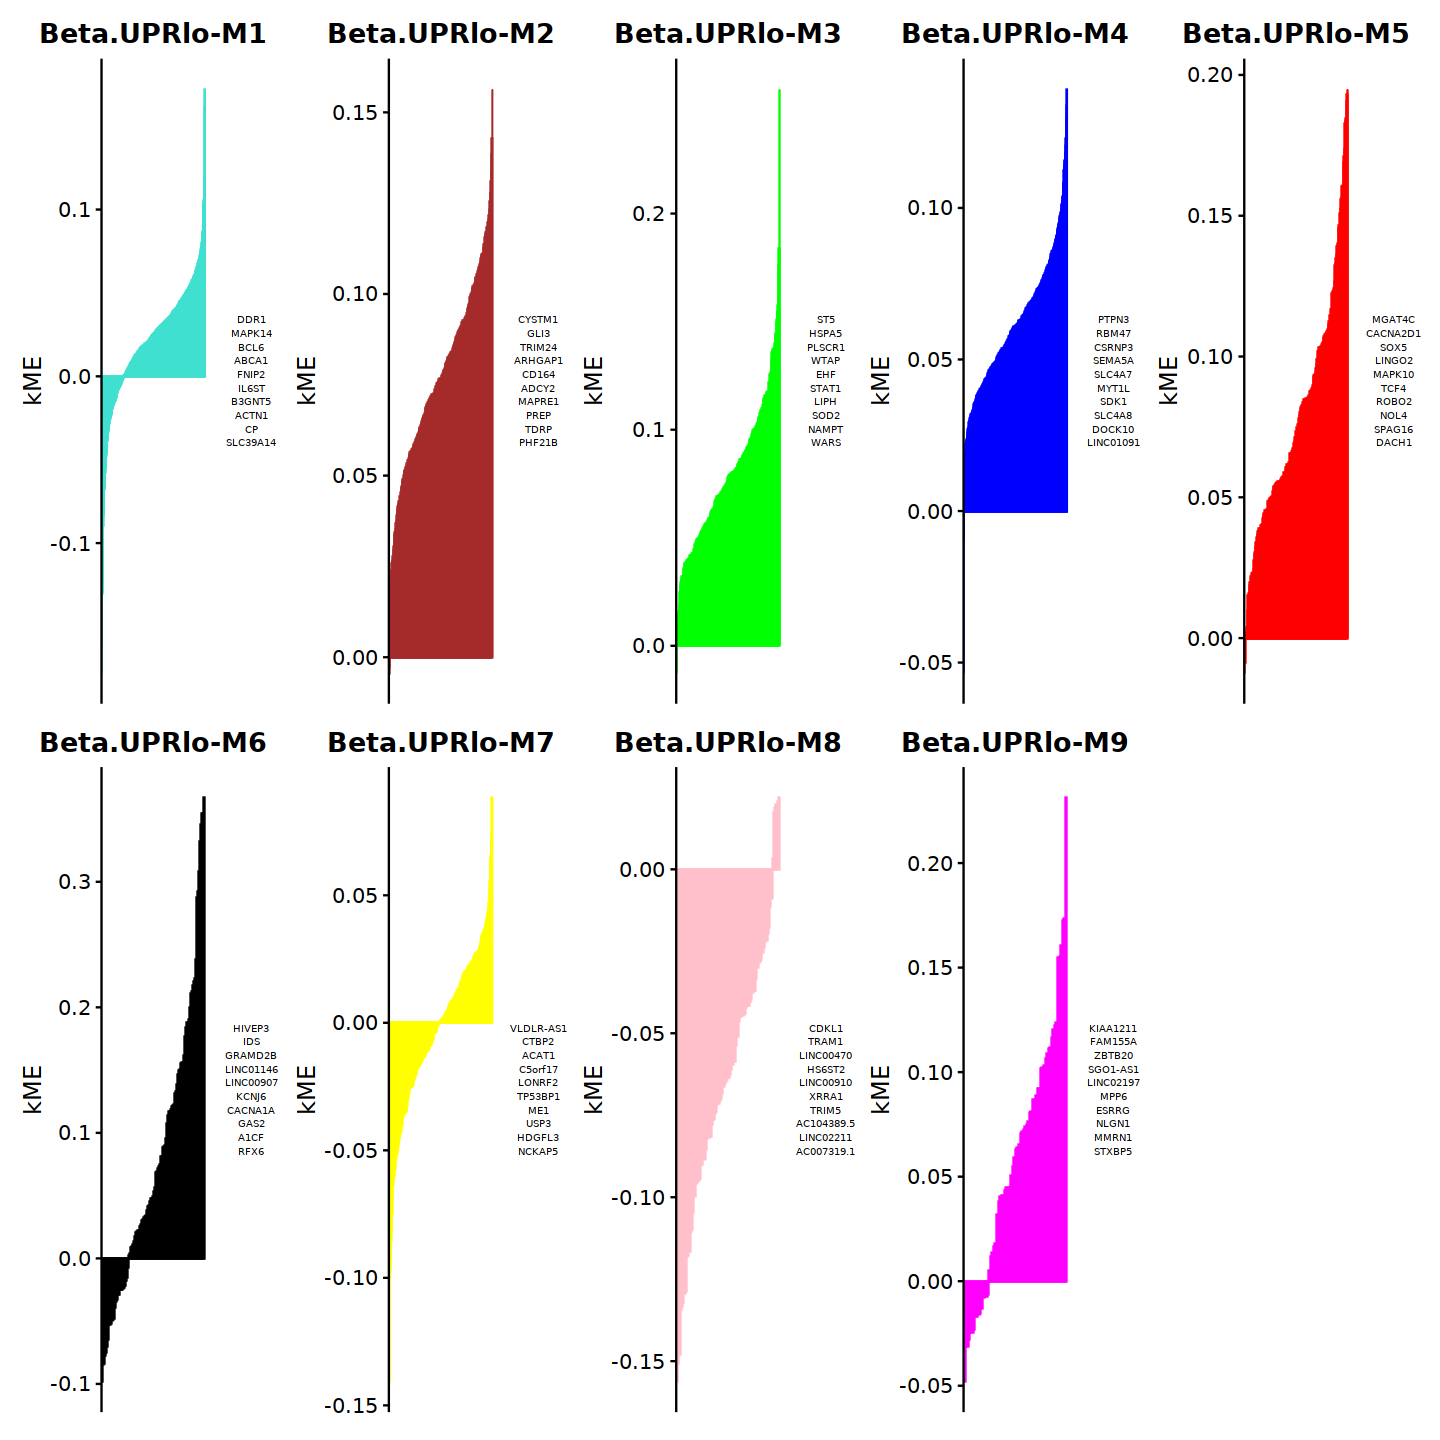

In [93]:
# plot genes ranked by kME for each module
options(repr.plot.width=12, repr.plot.height=12)
p <- PlotKMEs(seurat_obj, ncol=5)
p

In [82]:
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, binarizeCategoricalColumns(seurat_obj$condition))

In [85]:
colnames(seurat_obj@meta.data)

[1] "seurat_clusters"     "donor"               "condition"          
 [4] "lib"                 "value"               "cell.type"          
 [7] "metacell_grouping"   "data.cyt.vs.all"     "data.ffa.vs.all"    
[10] "data.hypoxia.vs.all" "data.unt.vs.all"

In [88]:
# list of traits to correlate
cur_traits <- c('data.cyt.vs.all', 'data.ffa.vs.all', 'data.hypoxia.vs.all', 'data.unt.vs.all')

seurat_obj <- ModuleTraitCorrelation(
  seurat_obj,
  traits = cur_traits,
  group.by='cell.type'
)

In [89]:
mt_cor <- GetModuleTraitCorrelation(seurat_obj)

names(mt_cor)

[1] "cor"  "pval" "fdr"

[1] "all_cells"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "A.Stellate"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "Acinar"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "Alpha"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "Beta.UPRhi"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "Beta.UPRlo"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "Delta"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "Ductal"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[1] "Endothelial"
[1] "data.cyt.vs.all"     "data.ffa.vs.all"     "data.hypoxia.vs.all"
[4] "data.unt.vs.all"    
[

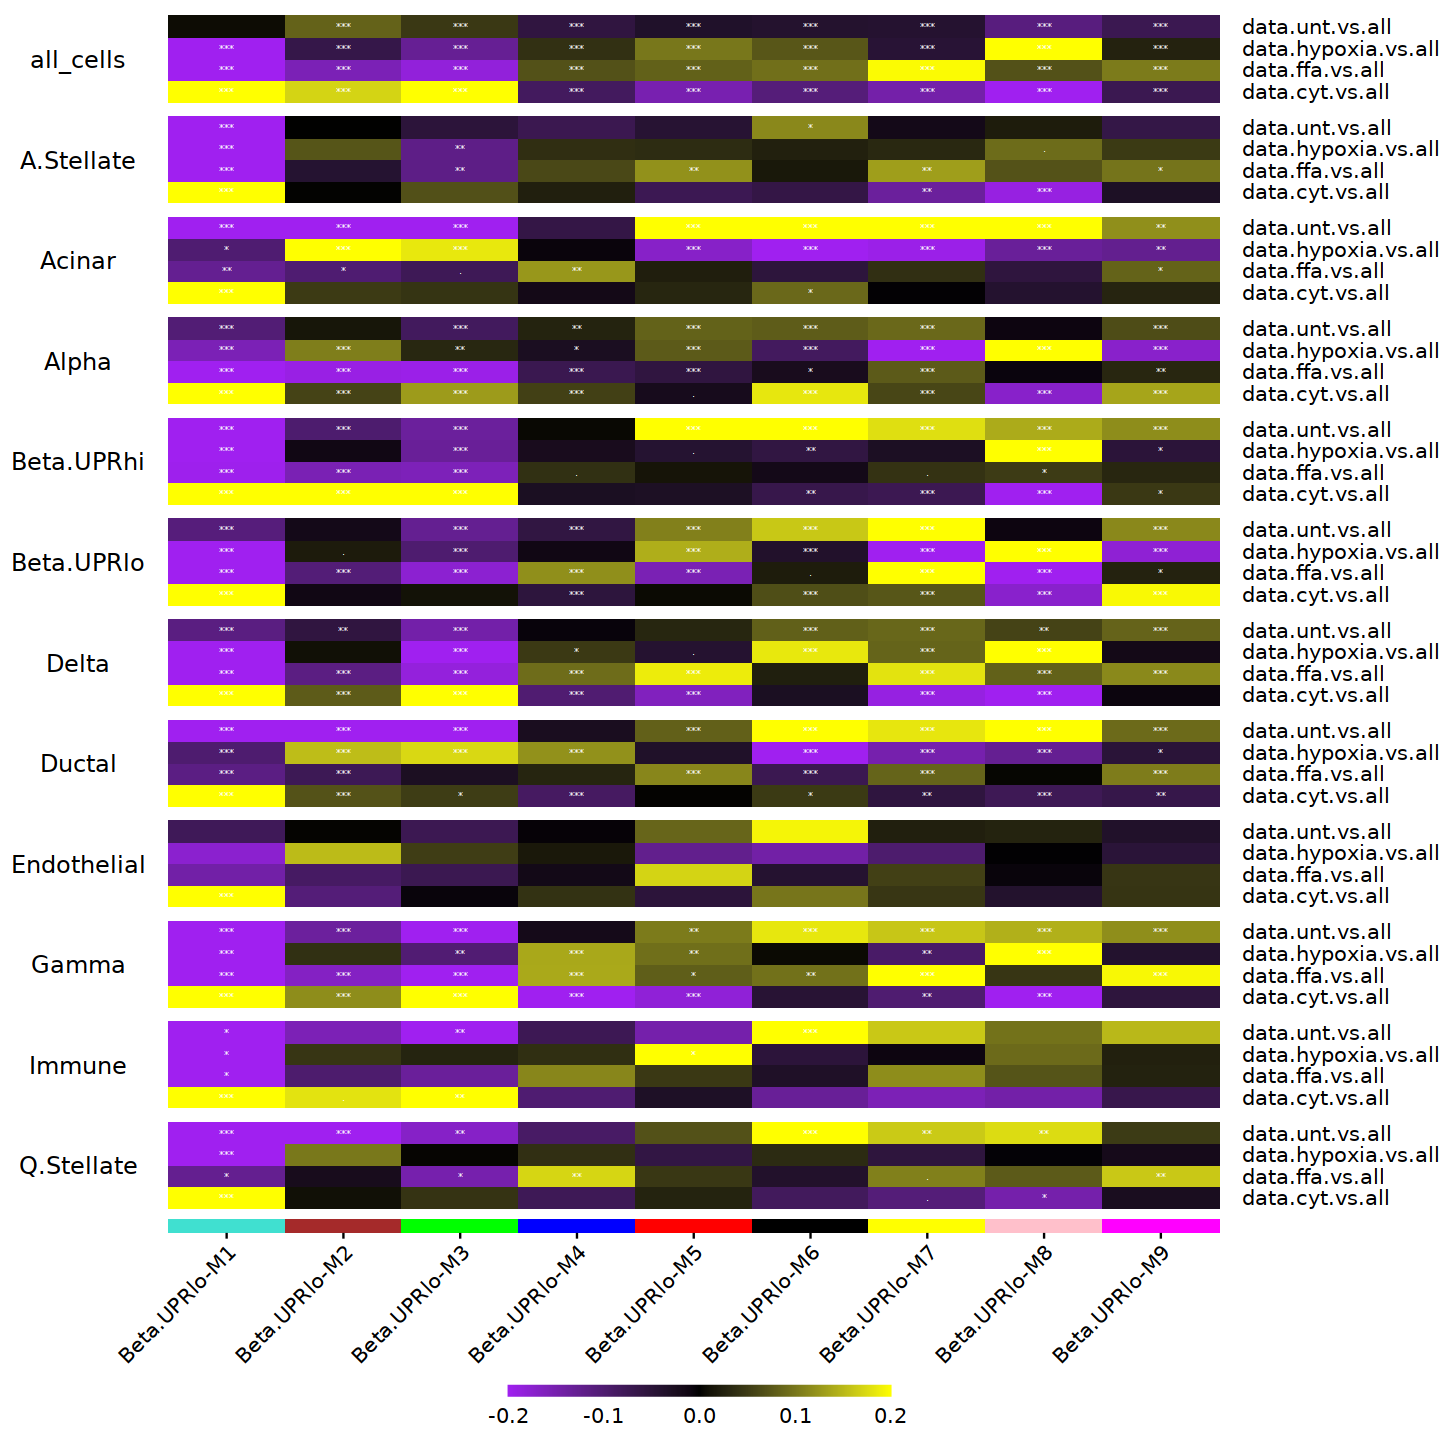

In [92]:
options(repr.plot.width=12, repr.plot.height=12)
PlotModuleTraitCorrelation(
  seurat_obj,
  label = 'fdr',
  label_symbol = 'stars',
  text_size = 2,
  text_digits = 2,
  text_color = 'white',
  high_color = 'yellow',
  mid_color = 'black',
  low_color = 'purple',
  plot_max = 0.2,
  combine=TRUE
)

---

# Scratch

In [ ]:
adata.loom <- Connect(filename ="31may22_islet_multiome.loom", mode = "r")

In [ ]:
adata.loom

Class: loom
Filename: /cellar/users/aklie/projects/beta_cell_networks/notebooks/scWGCNA/31may22_islet_multiome.loom
Access type: H5F_ACC_RDONLY
Attributes: last_modified
Listing:
       name    obj_type dataset.dims dataset.type_class
      attrs   H5I_GROUP         <NA>               <NA>
  col_attrs   H5I_GROUP         <NA>               <NA>
 col_graphs   H5I_GROUP         <NA>               <NA>
     layers   H5I_GROUP         <NA>               <NA>
     matrix H5I_DATASET 28977 x 3000          H5T_FLOAT
  row_attrs   H5I_GROUP         <NA>               <NA>
 row_graphs   H5I_GROUP         <NA>               <NA>

In [ ]:
adata <- as.Seurat(adata.loom, features = "features", cells = "cell_names")

ERROR: Error: Cannot find cell names dataset at col_attrs/cell_names


In [ ]:
adata.loom[["col_attrs"]]

Class: H5Group
Filename: /cellar/users/aklie/projects/beta_cell_networks/notebooks/scWGCNA/31may22_islet_multiome.loom
Group: /col_attrs
Attributes: last_modified
Listing:
          name    obj_type dataset.dims dataset.type_class
   ATAC.weight H5I_DATASET        28977          H5T_FLOAT
    SCT.weight H5I_DATASET        28977          H5T_FLOAT
 X_harmony.sct H5I_DATASET   50 x 28977          H5T_FLOAT
         X_pca H5I_DATASET   50 x 28977          H5T_FLOAT
    X_umap.wnn H5I_DATASET    2 x 28977          H5T_FLOAT
     cell.type H5I_DATASET        28977         H5T_STRING
     condition H5I_DATASET        28977         H5T_STRING
         donor H5I_DATASET        28977         H5T_STRING
   donor_demux H5I_DATASET        28977         H5T_STRING
           ffa H5I_DATASET        28977         H5T_STRING
< Printed 10, out of 30>